In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


df = pd.read_csv('D:/dissertation/session 1/Lloyds_data.csv')

# Convert the 'date' column to datetime format, specifying day-first formatting.
df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='%d/%m/%Y')

# Create a new column combining date and hour for chronological sorting.
df['sort_key'] = df['date'] + pd.to_timedelta(df['hour_of_day'], unit='h')

# Sort the DataFrame by individual identifiers and the newly created chronological sort key.
data_sorted = df.sort_values(by=['individual_id', 'sort_key'])

scaler = MinMaxScaler()

spend_reshaped = data_sorted['spend'].values.reshape(-1, 1)

# Normalize the reshaped 'spend' data and add it as a new column to the DataFrame.
data_sorted['spend_normalized'] = scaler.fit_transform(spend_reshaped)

# Define a function to check if an hour falls outside of typical working hours.
def check_non_working_hour(hour):
    if hour < 8 or hour > 18:
        return 1
    else:
        return 0

# Apply the function to create a binary column indicating non-working hours.
data_sorted['is_non_working_hour'] = data_sorted['hour_of_day'].apply(check_non_working_hour)
# Apply a lambda function to identify weekend days.
data_sorted['is_weekend'] = data_sorted['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# Initiate new columns to indicate the first occurrence of non-working hour and weekend spends.
data_sorted['first_non_working_hour'] = 0
data_sorted['first_weekend'] = 0

first_non_working_hour_idx = data_sorted[data_sorted['is_non_working_hour'] == 1].groupby('individual_id').head(1).index
first_weekend_spend_idx = data_sorted[data_sorted['is_weekend'] == 1].groupby('individual_id').head(1).index

data_sorted.loc[first_non_working_hour_idx, 'first_non_working_hour'] = 1
data_sorted.loc[first_weekend_spend_idx, 'first_weekend'] = 1

# Define a function to calculate hours until the next working hour based on the current hour.
def time_to_working_hour(hour):
    if hour < 8:
        return 8 - hour
    elif hour > 18:
        return hour - 18
    else:
        return 0

# Apply the function to calculate the time to the next working hour for non-working hours.
data_sorted['time_to_working_hour'] = data_sorted[data_sorted['is_non_working_hour'] == 1]['hour_of_day'].apply(time_to_working_hour)

# Normalize the 'time_to_working_hour' to a 0-1 scale.
min_value = data_sorted['time_to_working_hour'].min()
max_value = data_sorted['time_to_working_hour'].max()
data_sorted['time_to_working_hour_normalized'] = (data_sorted['time_to_working_hour'] - min_value) / (max_value - min_value)
data_sorted['time_to_working_hour_normalized'].fillna(0, inplace=True)
data_sorted['time_to_working_hour'].fillna(0, inplace=True)

# Calculate probabilities of spending during weekdays and working hours.
prob_weekday = (1 - data_sorted.groupby('individual_id')['is_weekend'].mean()).rename('prob_weekday')
prob_working_hours = (1 - data_sorted.groupby('individual_id')['is_non_working_hour'].mean()).rename('prob_working_hours')

# Map these probabilities back to the DataFrame to adjust risk weights based on spending behaviors.
data_sorted['prob_weekday'] = data_sorted['individual_id'].map(prob_weekday)
data_sorted['prob_working_hours'] = data_sorted['individual_id'].map(prob_working_hours)

# Adjust risk weights by multiplying the binary indicators with their respective probabilities.
data_sorted['adjusted_non_working_hour_risk'] = data_sorted['is_non_working_hour'] * data_sorted['prob_working_hours']
data_sorted['adjusted_weekend_risk'] = data_sorted['is_weekend'] * data_sorted['prob_weekday']

# Normalize the adjusted risk scores.
min_non_working_risk = data_sorted['adjusted_non_working_hour_risk'].min()
max_non_working_risk = data_sorted['adjusted_non_working_hour_risk'].max()
data_sorted['adjusted_non_working_hour_risk_normalized'] = (data_sorted['adjusted_non_working_hour_risk'] - min_non_working_risk) / (max_non_working_risk - min_non_working_risk)
data_sorted['adjusted_non_working_hour_risk_normalized'].fillna(0, inplace=True)

min_weekend_risk = data_sorted['adjusted_weekend_risk'].min()
max_weekend_risk = data_sorted['adjusted_weekend_risk'].max()
data_sorted['adjusted_weekend_risk_normalized'] = (data_sorted['adjusted_weekend_risk'] - min_weekend_risk) / (max_weekend_risk - min_weekend_risk)
data_sorted['adjusted_weekend_risk_normalized'].fillna(0, inplace=True)


# Define a function to mark the first two non-working hours and weekends for special analysis.
def mark_first_two(group):
    group['first_and_second_non_working_hour'] = 0
    group['first_and_second_weekend'] = 0

    non_working_hours = group['is_non_working_hour'] == 1

    if non_working_hours.sum() > 1:
        first_two_non_working = non_working_hours[non_working_hours].index[:2]
        group.loc[first_two_non_working, 'first_and_second_non_working_hour'] = 1
    elif non_working_hours.sum() == 1:
        first_non_working = non_working_hours.idxmax()
        group.loc[first_non_working, 'first_and_second_non_working_hour'] = 1

    weekends = group['is_weekend'] == 1
    if weekends.sum() > 1:
        first_two_weekend = weekends[weekends].index[:2]
        group.loc[first_two_weekend, 'first_and_second_weekend'] = 1
    elif weekends.sum() == 1:
        first_weekend = weekends.idxmax()
        group.loc[first_weekend, 'first_and_second_weekend'] = 1

    return group

# Apply the function to mark the first two instances of non-working hours and weekends.
data_sorted = data_sorted.groupby('individual_id').apply(mark_first_two)

# Calculate the probabilities of spending during non-working hours and weekends.
prob_non_working_hours = data_sorted.groupby('individual_id')['is_non_working_hour'].mean().rename('prob_non_working_hours')
prob_weekend = data_sorted.groupby('individual_id')['is_weekend'].mean().rename('prob_weekend')

# Map these probabilities to every row to create risk adjustment columns based on behavior.
data_sorted['prob_non_working_hours'] = data_sorted['individual_id'].map(prob_non_working_hours)
data_sorted['prob_weekend'] = data_sorted['individual_id'].map(prob_weekend)

standard_scaler = StandardScaler()

# Normalising probabilities using StandardScaler.
data_sorted['prob_non_working_hours_normalized'] = standard_scaler.fit_transform(data_sorted[['prob_non_working_hours']])
data_sorted['prob_weekend_normalized'] = standard_scaler.fit_transform(data_sorted[['prob_weekend']])

C:\Users\DELL\AppData\Local\Temp\ipykernel_20424\2732673151.py:118: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_sorted = data_sorted.groupby('individual_id').apply(mark_first_two)


In [9]:

# Calculate the 3-period moving average of spending for each individual.
data_sorted['spend_moving_avg'] = data_sorted.groupby('individual_id')['spend'].rolling(window=3).mean().reset_index(level=0, drop=True)

# Calculate the difference between the actual spend and its moving average.
data_sorted['spend_diff'] = data_sorted['spend'] - data_sorted['spend_moving_avg']
data_sorted['spend_diff'] = data_sorted['spend_diff'].fillna(0)

# Create a flag that marks differences greater than or equal to 15 as 1, others as 0.
data_sorted['spend_diff_flag'] = (data_sorted['spend_diff'] >= 15).astype(int)

# Initialize a flag to track processing status of each record.
data_sorted['processed_flag'] = False

# Identify all records with a 'spend_diff_flag' of 1 to process them.
indexes = data_sorted[data_sorted['spend_diff_flag'] == 1].index

# Iterate through the flagged records and process each one if it hasn't been processed yet.
for index in indexes:
    if not data_sorted.at[index, 'processed_flag']:
        start_date = data_sorted.at[index, 'date']
        end_date = start_date + pd.Timedelta(days=4)
        # Select records within the 5-day window for the same individual.
        mask = (data_sorted['individual_id'] == data_sorted.at[index, 'individual_id']) & \
               (data_sorted['date'] >= start_date) & (data_sorted['date'] <= end_date)
        data_sorted.loc[mask & (data_sorted.index != index), 'processed_flag'] = True
        # Reset the 'spend_diff_flag' to 0 for all other records within the window that have the flag set.
        data_sorted.loc[mask & (data_sorted.index != index) & (data_sorted['spend_diff_flag'] == 1), 'spend_diff_flag'] = 0

data_sorted.drop(columns=['processed_flag'], inplace=True)

# Initialize a new column to mark the first two high spend instances as 0.
data_sorted['first_two_high_spend'] = 0
high_spend_indexes = data_sorted[data_sorted['spend_diff_flag'] == 1].groupby('individual_id').head(2).index
data_sorted.loc[high_spend_indexes, 'first_two_high_spend'] = 1



E:\anoconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\anoconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


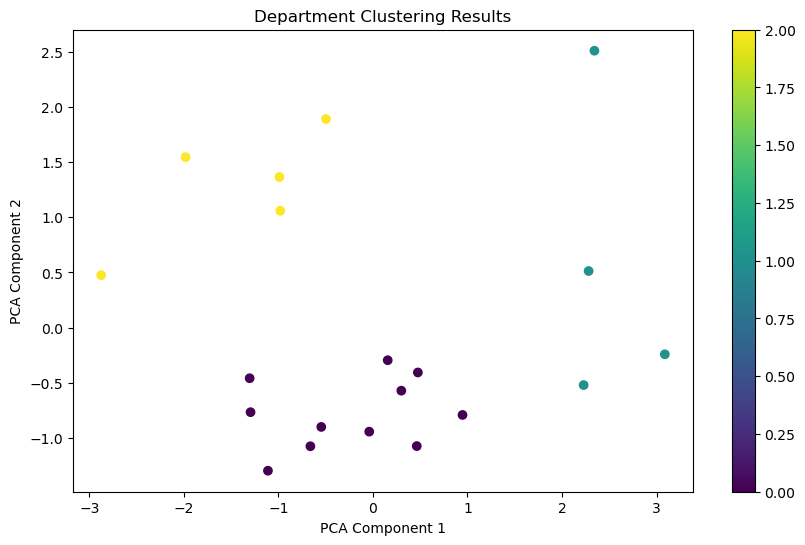

In [10]:

# Group data by 'department' and calculate statistical measures such as median spending, standard deviation of spending, 
# and mean of adjusted risks for non-working hours and weekends.
department_stats = data_sorted.groupby('department').agg(
    median_spend=pd.NamedAgg(column='spend', aggfunc='median'),
    std_spend=pd.NamedAgg(column='spend', aggfunc='std'),
    non_working_hour_ratio=pd.NamedAgg(column='adjusted_non_working_hour_risk', aggfunc='mean'),
    weekend_ratio=pd.NamedAgg(column='adjusted_weekend_risk', aggfunc='mean')
)

# Define feature weights based on importance for analysis; equal weights are assumed here.
weights = np.array([1, 1, 1, 1])

# Normalize the features to have zero mean and unit variance for better performance in PCA and clustering.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(department_stats)
features_weighted = features_scaled * weights

# Perform PCA to reduce dimensionality to 2 components for visualization.
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_weighted)

# Cluster departments using K-means clustering, specifying 3 clusters based on the PCA-reduced features.
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(features_weighted)

# Visualize the clustering results using a scatter plot.
plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis', label=clusters)
plt.title('Department Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter)
plt.show()


Explained variance ratio: [0.57987511 0.29744031]
PCA components (loadings):
                              PC1       PC2
median_spend           -0.600257  0.165030
std_spend              -0.629459 -0.033846
non_working_hour_ratio -0.446811 -0.555555
weekend_ratio          -0.209364  0.814235


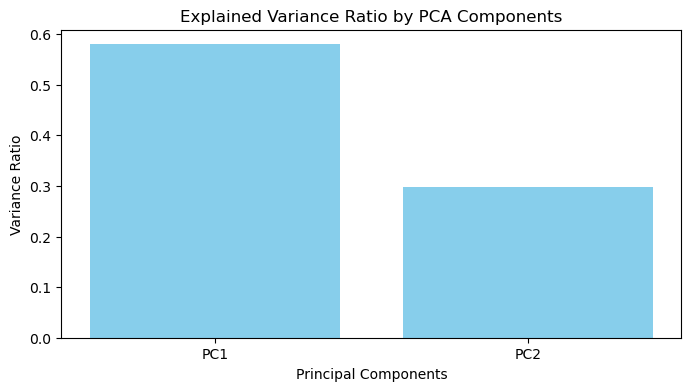

In [11]:
# Output the proportion of variance explained by each of the selected principal components.
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Create a DataFrame to view the loadings of the principal components.
pca_loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=department_stats.columns)
print("PCA components (loadings):\n", pca_loadings)

# Visualize the explained variance ratio of the PCA components.
plt.figure(figsize=(8, 4))
plt.bar(['PC1', 'PC2'], pca.explained_variance_ratio_, color='skyblue')
plt.title('Explained Variance Ratio by PCA Components')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.show()


In [12]:
# Add the clustering results as a new column to the 'department_stats' DataFrame.
department_stats['cluster'] = clusters
print(department_stats)

                    median_spend  std_spend  non_working_hour_ratio  \
department                                                            
accounting                 4.930  16.775324                0.060239   
development                4.350   8.626367                0.049735   
exec                       4.710   8.426916                0.040063   
finance                    5.110  18.393438                0.071692   
general                    4.830   8.574802                0.046544   
human_resources            5.080  17.118242                0.066747   
investor_relations         5.230  20.681596                0.048373   
it                         4.990  19.898530                0.074467   
legal                      4.930  17.884833                0.061431   
marketing                  5.150  19.986498                0.063968   
ops                        5.260  22.835263                0.067807   
product_management         5.960  23.685775                0.068800   
produc

In [13]:
# Ensure that the 'department_stats' DataFrame uses department names as its index.
if not department_stats.index.name == 'department':
    department_stats.set_index('department', inplace=True)

# Create a dictionary that maps each department to its corresponding cluster label.
cluster_mapping = department_stats['cluster'].to_dict()

# Map the cluster labels from the 'department_stats' DataFrame to each record in the original dataset based on department names.
# This step enriches the 'data_sorted' DataFrame with the cluster information, associating each transaction or data point with a cluster group.
data_sorted['cluster_label'] = data_sorted['department'].map(cluster_mapping)

columns_to_drop = [
    'time_to_working_hour', 
    'prob_weekday', 
    'prob_working_hours', 
    'adjusted_non_working_hour_risk', 
    'adjusted_weekend_risk', 
    'prob_non_working_hours', 
    'prob_weekend'
]

data_sorted.drop(columns=columns_to_drop, axis=1, inplace=True)

In [14]:

file_path = 'D:/dissertation/session 1/feature.csv'

data_sorted.to_csv(file_path, index=False)